## Import Libraries

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Oct 28 08:32:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import torch
!pip install transformers
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

     |████████████████████████████████| 2.9 MB 6.8 MB/s 
     |████████████████████████████████| 895 kB 74.2 MB/s 
     |████████████████████████████████| 56 kB 6.1 MB/s 
     |████████████████████████████████| 3.3 MB 27.6 MB/s 
     |████████████████████████████████| 596 kB 83.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Load Data

In [ ]:
# Data Loading
"""
Here in this notebook and model, the data is loaded directly into the notebook intasnce directly.
Loading data from the drive to notebook instance makes training slower, because of batch loading.
"""
!pip install datasets
from datasets import load_dataset

     |████████████████████████████████| 290 kB 8.6 MB/s 
     |████████████████████████████████| 1.3 MB 71.2 MB/s 
     |████████████████████████████████| 243 kB 92.4 MB/s 
     |████████████████████████████████| 125 kB 85.9 MB/s 
     |████████████████████████████████| 271 kB 85.5 MB/s 
     |████████████████████████████████| 160 kB 92.7 MB/s 


In [ ]:
# split train and test set
train_dataset = load_dataset('yelp_polarity', split = "train")
test_dataset = load_dataset('yelp_polarity', split = "test")

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/166M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset yelp_polarity downloaded and prepared to /root/.cache/huggingface/datasets/yelp_polarity/plain_text/1.0.0/a770787b2526bdcbfc29ac2d9beb8e820fbc15a03afd3ebc4fb9d8529de57544. Subsequent calls will reuse this data.


Reusing dataset yelp_polarity (/root/.cache/huggingface/datasets/yelp_polarity/plain_text/1.0.0/a770787b2526bdcbfc29ac2d9beb8e820fbc15a03afd3ebc4fb9d8529de57544)


In [ ]:
# displaying train and test set features
print("train_dataset:", display(train_dataset))
print("test_dataset:", display(test_dataset))

Dataset({
    features: ['text', 'label'],
    num_rows: 560000
})

train_dataset: None


Dataset({
    features: ['text', 'label'],
    num_rows: 38000
})

test_dataset: None


In [ ]:
# converting to dataframe
train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)

## Data Preprocessing

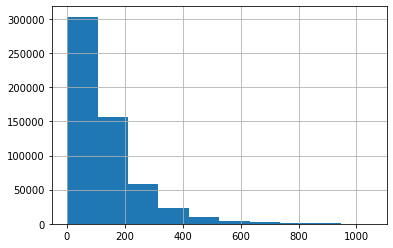

In [ ]:
# get length of all the reviews in the train set
seq_len = [len(i.split()) for i in train_df["text"]]

pd.Series(seq_len).hist(bins = 10)

In [ ]:
s= pd.Series(seq_len)
s.quantile([.50, .60, .70, .75, .80, .85, .90, .95])

0.50     97.0
0.60    121.0
0.70    153.0
0.75    174.0
0.80    199.0
0.85    232.0
0.90    282.0
0.95    372.0
dtype: float64

In [ ]:
print(f"train df shape: {train_df.shape}")
print(f"test df shape: {test_df.shape}")

train df shape: (560000, 2)
test df shape: (38000, 2)


In [ ]:
# Dropping last n rows using drop to test the model
#n = 510000
#train_df.drop(train_df.tail(n).index, inplace = True)

In [ ]:
print(f"train df type: {type(train_df)}")
print(f"train df shape: {train_df.shape}")
print(f"test df shape: {test_df.shape}")

train df type: <class 'pandas.core.frame.DataFrame'>
train df shape: (560000, 2)
test df shape: (38000, 2)


## Load Pretrained Model and Tokenizer

In [ ]:
# Define pretrained tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Tokenizer
X = list(train_df["text"])
y = list(train_df["label"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=256)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=256)

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [ ]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

## Develop and Train the BERT Model

In [ ]:
# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

Training arguements
https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments

In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="bert-output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    seed=0,
    load_best_model_at_end=True,
)


Trainer  https://huggingface.co/transformers/main_classes/trainer.html

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)],
)

In [ ]:
# Train pre-trained model
trainer.train()

***** Running training *****
  Num examples = 504000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 31500


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.219400,0.140724,0.946125,0.951629,0.939889,0.945723
1000,0.157300,0.150949,0.944107,0.973030,0.913392,0.942268
1500,0.152000,0.127359,0.953500,0.953215,0.953692,0.953453
2000,0.142600,0.140300,0.949732,0.932577,0.969426,0.950644
2500,0.138500,0.133588,0.949571,0.927815,0.974861,0.950757
3000,0.129700,0.133850,0.954250,0.938936,0.971572,0.954975
3500,0.132200,0.118604,0.957946,0.970807,0.944180,0.957308
4000,0.123000,0.119816,0.955857,0.935912,0.978616,0.956788
4500,0.124000,0.122752,0.957393,0.948016,0.967745,0.957779
5000,0.122900,0.112941,0.960054,0.970313,0.949043,0.959560


***** Running Evaluation *****
  Num examples = 56000
  Batch size = 32
Saving model checkpoint to bert-output/checkpoint-500
Configuration saved in bert-output/checkpoint-500/config.json
Model weights saved in bert-output/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 56000
  Batch size = 32
Saving model checkpoint to bert-output/checkpoint-1000
Configuration saved in bert-output/checkpoint-1000/config.json
Model weights saved in bert-output/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 56000
  Batch size = 32
Saving model checkpoint to bert-output/checkpoint-1500
Configuration saved in bert-output/checkpoint-1500/config.json
Model weights saved in bert-output/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 56000
  Batch size = 32
Saving model checkpoint to bert-output/checkpoint-2000
Configuration saved in bert-output/checkpoint-2000/config.json
Model weights saved in bert-output/c

TrainOutput(global_step=23000, training_loss=0.10175430355901303, metrics={'train_runtime': 38578.0556, 'train_samples_per_second': 26.129, 'train_steps_per_second': 0.817, 'total_flos': 9.682486837248e+16, 'train_loss': 0.10175430355901303, 'epoch': 1.46})

In [ ]:
# Load test data
X_test = list(test_df["text"])
y_test = test_df["label"]
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=256)

In [ ]:
y_test.value_counts()

1    19000
0    19000
Name: label, dtype: int64

In [ ]:
# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

## Loading saved model weights

In [ ]:
# Load trained model
model_path = "/content/bert-output/checkpoint-18000"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

loading configuration file /content/bert-output/checkpoint-14500/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file /content/bert-output/checkpoint-14500/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All t

In [ ]:
# Define test trainer
test_trainer = Trainer(model)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


## Model Evaluation

In [ ]:
# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 38000
  Batch size = 8


In [ ]:
# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [ ]:
# Print a classification report
target_names = ["class 0", "class 1"]
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

     class 0       0.97      0.97      0.97     19000
     class 1       0.97      0.97      0.97     19000

    accuracy                           0.97     38000
   macro avg       0.97      0.97      0.97     38000
weighted avg       0.97      0.97      0.97     38000



In [ ]:
# Report the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[18482,   518],
       [  649, 18351]])

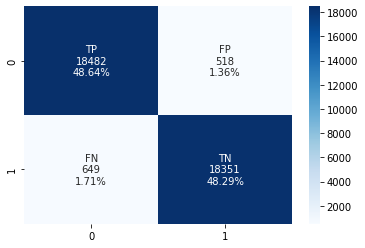

In [ ]:
# Plotting confusion matrix
group_names = ["TP","FP","FN","TN"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

In [ ]:
print("End of the notebook ")

End of the notebook 
